In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
%matplotlib inline

In [2]:
# config
melanoma_external_malignant_256 = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/melanoma_external_malignant_256/"
SIIM_ISIC_Melanoma_Classification = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"
Output = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/Output/"

In [17]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=382, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [18]:
#画像の表示
def display_img(img):
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #cv2とmatplotlibではカラーの解釈が違う。
    plt.imshow(rgb)
    plt.show()

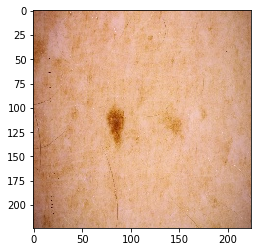

In [19]:
im_path = os.path.join(SIIM_ISIC_Melanoma_Classification + 'pad_jpg/train/224_224/', "ISIC_0015719.jpg")
x = cv2.imread(im_path)
display_img(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


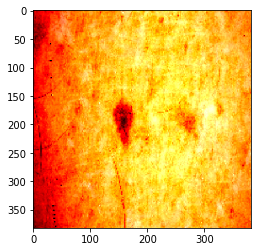

In [20]:
x_trs = train_transform(x)
x_trs = x_trs.permute(1, 2, 0)
x_trs = x_trs.to('cpu').detach().numpy().copy()
display_img(x_trs)

In [21]:
x.shape

(224, 224, 3)

In [22]:
x_trs.shape

(382, 382, 3)

## metadata

In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
%matplotlib inline

In [2]:
# config
melanoma_external_malignant_256 = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/melanoma_external_malignant_256/"
SIIM_ISIC_Melanoma_Classification = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"
Output = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/Output/"

In [3]:
#train_concatとtestに被るデータはない。
train_TD = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
train_TD = train_TD.drop(['diagnosis','benign_malignant'], axis=1)
#train_TD = pd.read_csv(melanoma_external_malignant_256 + 'train_concat.csv')
test_TD  = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')
sub_TD   = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')

train_TD.shape, test_TD.shape, sub_TD.shape

((33126, 6), (10982, 5), (10982, 2))

In [4]:
type(train_TD)

pandas.core.frame.DataFrame

In [5]:
train_TD.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,0


In [11]:
patient_cnt = train_TD.groupby("patient_id").count()["image_name"]

In [12]:
patient_cnt.max()

115

In [13]:
patient_cnt.head()

patient_id
IP_0001230     6
IP_0019713    13
IP_0036322     5
IP_0038436     3
IP_0038545    28
Name: image_name, dtype: int64

In [25]:
train_TD_cut = train_TD[train_TD.patient_id == "IP_0038436"]
train_TD_cut.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target
6704,ISIC_2102371,IP_0038436,male,55.0,torso,0
9154,ISIC_2838960,IP_0038436,male,55.0,lower extremity,0
12517,ISIC_3856233,IP_0038436,male,55.0,torso,0


In [28]:
train_tmp = []
train_tmp.append(train_TD_cut["image_name"])

In [29]:
train_tmp

[6704     ISIC_2102371
 9154     ISIC_2838960
 12517    ISIC_3856233
 Name: image_name, dtype: object]